In [ ]:
# prompt: mounts google drive

from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage

# Load the dataset
try:
    df = pd.read_csv('/content/simulated_health_wellness_data.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'simulated_health_wellness_data.csv' not found.")
    print("Please upload the file to your Colab environment or ensure the path is correct.")
    # Exit or handle the error gracefully if in a script
    exit()

Dataset loaded successfully!



--- Data Exploration ---
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exercise_Time_Min      200 non-null    float64
 1   Healthy_Meals_Per_Day  200 non-null    int64  
 2   Sleep_Hours_Per_Night  200 non-null    float64
 3   Stress_Level           200 non-null    int64  
 4   BMI                    200 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 7.9 KB
None

First 5 rows of the dataset:
   Exercise_Time_Min  Healthy_Meals_Per_Day  Sleep_Hours_Per_Night  \
0          34.967142                      5               7.618856   
1          28.617357                      8               4.105473   
2          36.476885                      4               6.024123   
3          45.230299                      1               8.565319   
4          27.658466                      3              

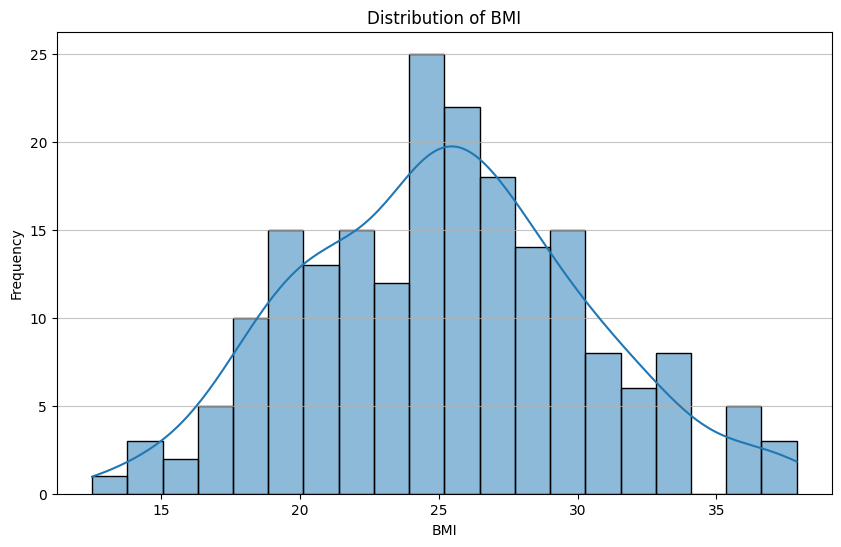

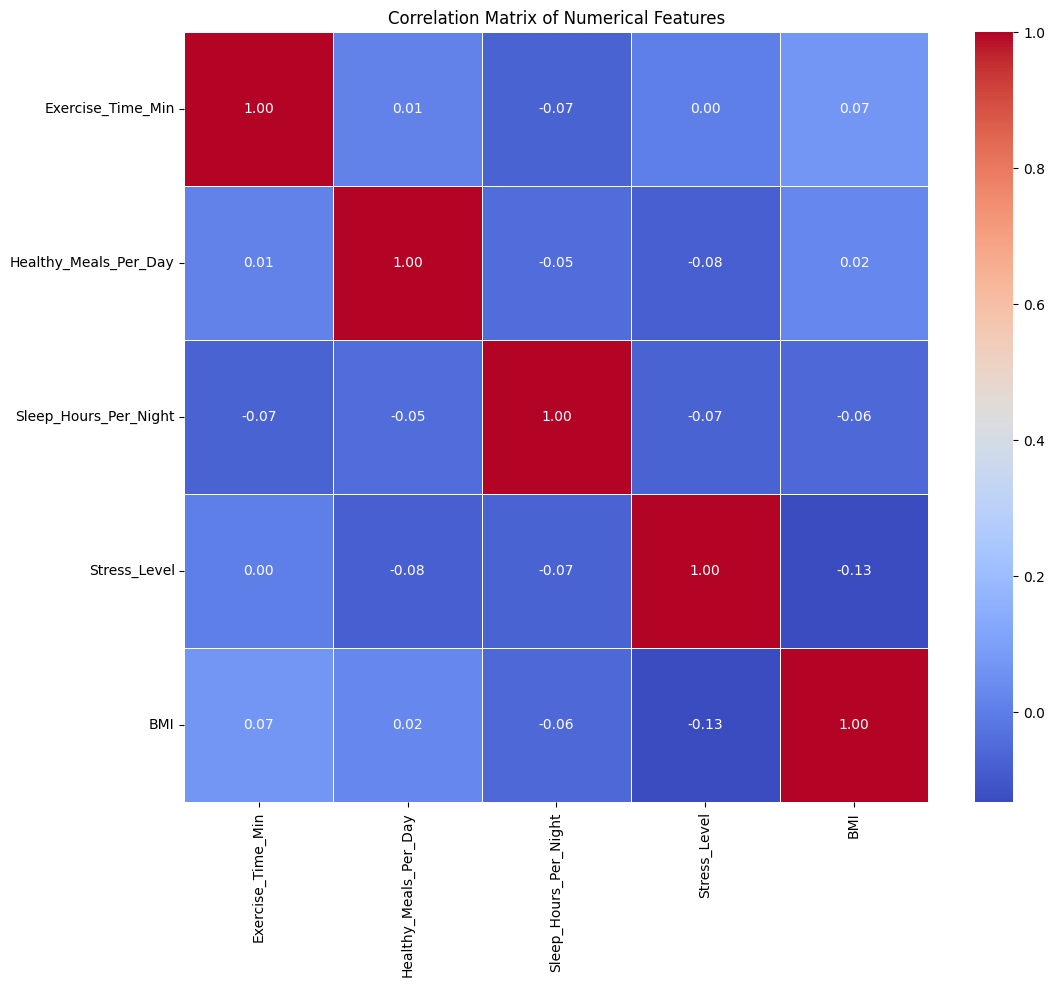


Generating pairplot for: ['BMI', 'Stress_Level'] (This might take a moment)...


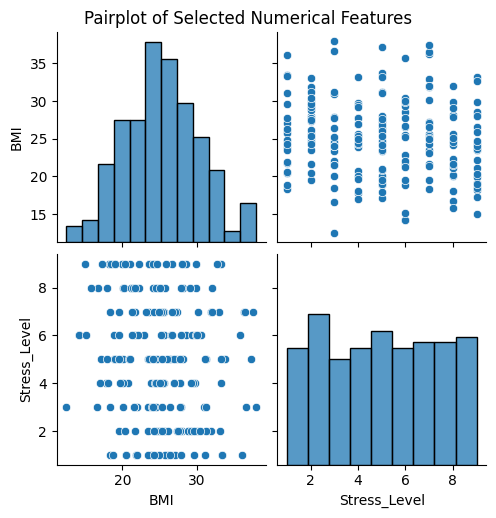


Data scaled successfully for clustering and PCA.


In [3]:
# Block 2: Exploratory Data Analysis (EDA)

print("\n--- Data Exploration ---")
print("Dataset Info:")
print(df.info())

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Identify numerical features for EDA
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'Patient_ID' if it exists and is not a feature for analysis
if 'Patient_ID' in numerical_features:
    numerical_features.remove('Patient_ID')
if 'ID' in numerical_features: # assuming 'ID' might also be present
    numerical_features.remove('ID')

print(f"\nNumerical features for analysis: {numerical_features}")

# Distribution of a few key numerical features
if 'Age' in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Age'], bins=20, kde=True)
    plt.title('Distribution of Age')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

if 'BMI' in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['BMI'], bins=20, kde=True)
    plt.title('Distribution of BMI')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Count plot for 'Gender' if it's a column
if 'Gender' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Gender', data=df)
    plt.title('Distribution of Gender')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

# Correlation matrix for numerical features
if len(numerical_features) > 1:
    plt.figure(figsize=(12, 10))
    corr_matrix = df[numerical_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

# Pairplot for a subset of numerical features (can be computationally intensive for many features)
# Select a few key features for pairplot if numerical_features list is long
if len(numerical_features) > 2:
    # Adjust this subset based on your data's actual columns
    pairplot_features = ['Age', 'BMI', 'Sleep_Hours', 'Stress_Level']
    # Filter to ensure features actually exist
    existing_pairplot_features = [f for f in pairplot_features if f in df.columns]
    if existing_pairplot_features:
        print(f"\nGenerating pairplot for: {existing_pairplot_features} (This might take a moment)...")
        sns.pairplot(df[existing_pairplot_features])
        plt.suptitle('Pairplot of Selected Numerical Features', y=1.02)
        plt.show()
    else:
        print("\nCould not find specified features for pairplot.")
else:
    print("\nNot enough numerical features for a meaningful pairplot.")

# Prepare data for clustering and PCA:
# Select relevant features (excluding categorical and ID columns, but include all numerical features identified)
# Make sure to handle non-numeric columns if they exist (e.g., one-hot encode or drop)
# For this dataset, we assume direct numerical features.
features_for_modeling = numerical_features # Use the identified numerical features

if not features_for_modeling:
    raise ValueError("No numerical features found for clustering and PCA. Please check your dataset.")

X = df[features_for_modeling]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nData scaled successfully for clustering and PCA.")


--- K-Means Clustering ---


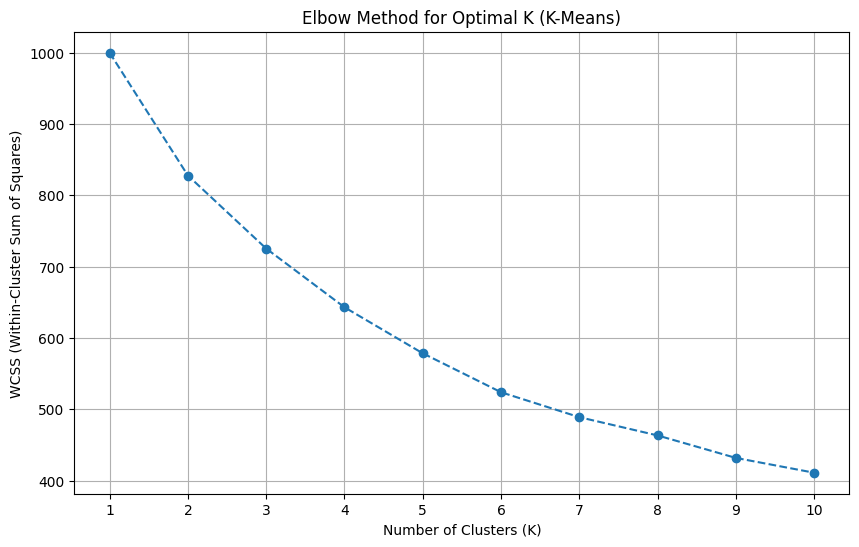


Using optimal K = 3 for clustering (chosen from Elbow Method).

K-Means Clustering Results (K=3):
KMeans_Cluster
0    75
1    54
2    71
Name: count, dtype: int64
Silhouette Score for K-Means (Original Data): 0.155

K-Means Cluster Characteristics (Mean Values):
                Exercise_Time_Min  Healthy_Meals_Per_Day  \
KMeans_Cluster                                             
0                       36.942131               3.173333   
1                       23.167237               3.425926   
2                       26.715035               2.140845   

                Sleep_Hours_Per_Night  Stress_Level        BMI  
KMeans_Cluster                                                  
0                            6.466737      4.000000  27.823493  
1                            8.170495      3.574074  25.309904  
2                            6.485979      7.126761  22.204294  


In [4]:
# Block 3: Clustering - K-Means

print("\n--- K-Means Clustering ---")

# Determine optimal number of clusters using Elbow Method
# It's good practice to run KMeans with n_init to avoid local minima
wcss = []
k_range = range(1, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (K-Means)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

# Based on the elbow method, visually select an optimal K.
# For demonstration, let's assume optimal K=3 (adjust based on your plot)
optimal_k = 3
print(f"\nUsing optimal K = {optimal_k} for clustering (chosen from Elbow Method).")

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nK-Means Clustering Results (K={optimal_k}):")
print(df['KMeans_Cluster'].value_counts().sort_index())
print(f"Silhouette Score for K-Means (Original Data): {silhouette_score(X_scaled, df['KMeans_Cluster']):.3f}")

# Analyze K-Means Cluster Characteristics
print("\nK-Means Cluster Characteristics (Mean Values):")
cluster_means_kmeans = df.groupby('KMeans_Cluster')[features_for_modeling].mean()
print(cluster_means_kmeans)

# Visualize K-Means Clusters (using PCA for 2D visualization)
# First, perform PCA to 2 components for visualization purposes only
pca_viz = PCA(n_components=2)
X_pca_viz = pca_viz.fit_transform(X_scaled)
df_pca_viz = pd.DataFrame(X_pca_viz, columns=['PC1', 'PC2'])
df_pca_viz['KMeans_Cluster'] = df['KMeans_Cluster']

fig = px.scatter(df_pca_viz, x='PC1', y='PC2', color='KMeans_Cluster',
                 title='K-Means Clusters (2D PCA Visualization)',
                 hover_data={'KMeans_Cluster':True})
fig.update_layout(height=600, width=800)
fig.show()


--- Hierarchical Clustering ---


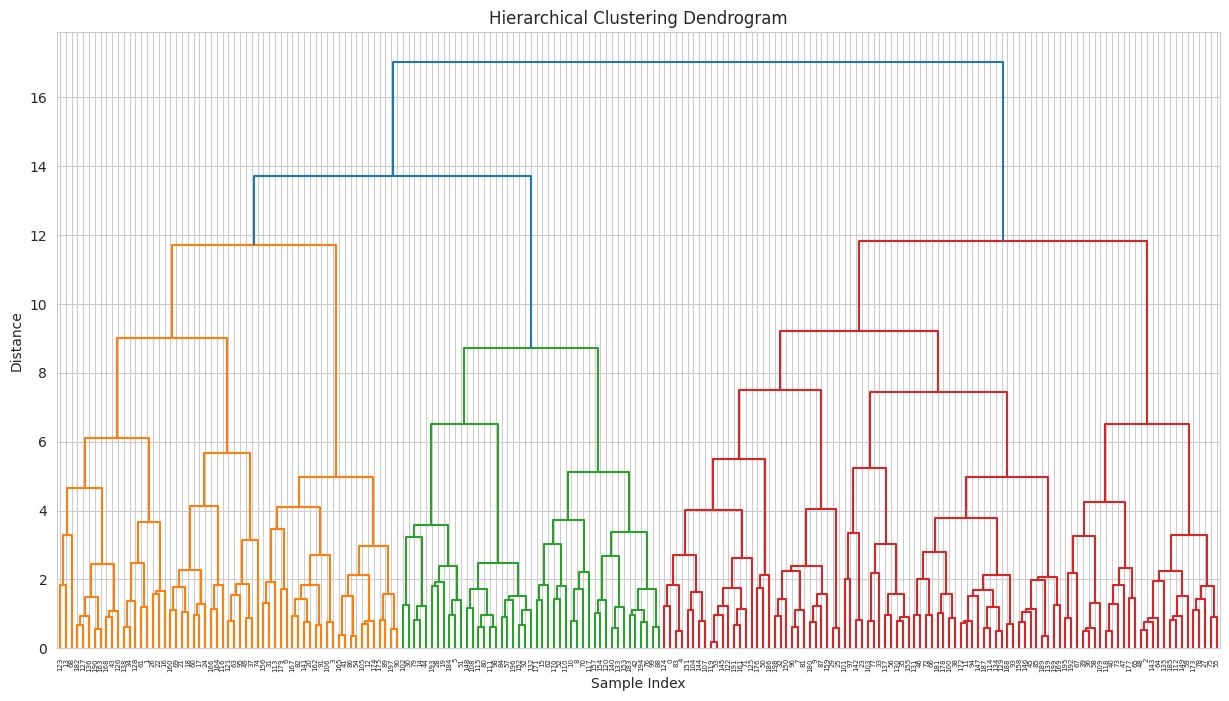


Hierarchical Clustering Results (K=3):
Hierarchical_Cluster
0    96
1    59
2    45
Name: count, dtype: int64
Silhouette Score for Hierarchical Clustering (Original Data): 0.136

Hierarchical Cluster Characteristics (Mean Values):
                      Exercise_Time_Min  Healthy_Meals_Per_Day  \
Hierarchical_Cluster                                             
0                             30.450182               3.187500   
1                             31.139440               2.288136   
2                             25.733636               2.977778   

                      Sleep_Hours_Per_Night  Stress_Level        BMI  
Hierarchical_Cluster                                                  
0                                  7.302486      3.322917  27.761629  
1                                  5.707485      6.338983  25.025856  
2                                  7.754138      6.800000  19.741329  


In [ ]:
# Block 4: Clustering - Hierarchical Clustering

print("\n--- Hierarchical Clustering ---")

# Generate the linkage matrix for dendrogram
# 'ward' linkage minimizes the variance within each cluster
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Apply AgglomerativeClustering based on the chosen optimal_k from K-Means
# (or by cutting the dendrogram at a specific height)
hierarchical_cluster = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df['Hierarchical_Cluster'] = hierarchical_cluster.fit_predict(X_scaled)

print(f"\nHierarchical Clustering Results (K={optimal_k}):")
print(df['Hierarchical_Cluster'].value_counts().sort_index())
print(f"Silhouette Score for Hierarchical Clustering (Original Data): {silhouette_score(X_scaled, df['Hierarchical_Cluster']):.3f}")

# Analyze Hierarchical Cluster Characteristics
print("\nHierarchical Cluster Characteristics (Mean Values):")
cluster_means_hierarchical = df.groupby('Hierarchical_Cluster')[features_for_modeling].mean()
print(cluster_means_hierarchical)

# Visualize Hierarchical Clusters (using PCA for 2D visualization)
df_pca_viz['Hierarchical_Cluster'] = df['Hierarchical_Cluster'] # Re-use the PCA components from K-Means viz

fig = px.scatter(df_pca_viz, x='PC1', y='PC2', color='Hierarchical_Cluster',
                 title='Hierarchical Clusters (2D PCA Visualization)',
                 hover_data={'Hierarchical_Cluster':True})
fig.update_layout(height=600, width=800)
fig.show()


--- Principal Component Analysis (PCA) ---


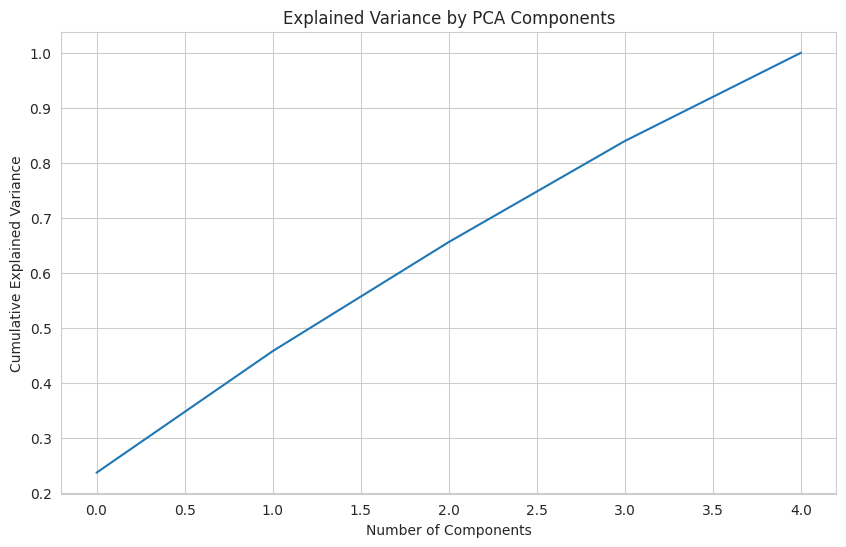


Explained Variance Ratio for 2 PCA Components:
[0.23691549 0.22082517]
Total Explained Variance by 2 components: 0.458

PCA Components (Loadings - weights of original features on each PC):
     Exercise_Time_Min  Healthy_Meals_Per_Day  Sleep_Hours_Per_Night  \
PC1           0.343398               0.395626              -0.220185   
PC2          -0.478061               0.060977               0.687225   

     Stress_Level       BMI  
PC1     -0.530921  0.628649  
PC2     -0.543546  0.004418  


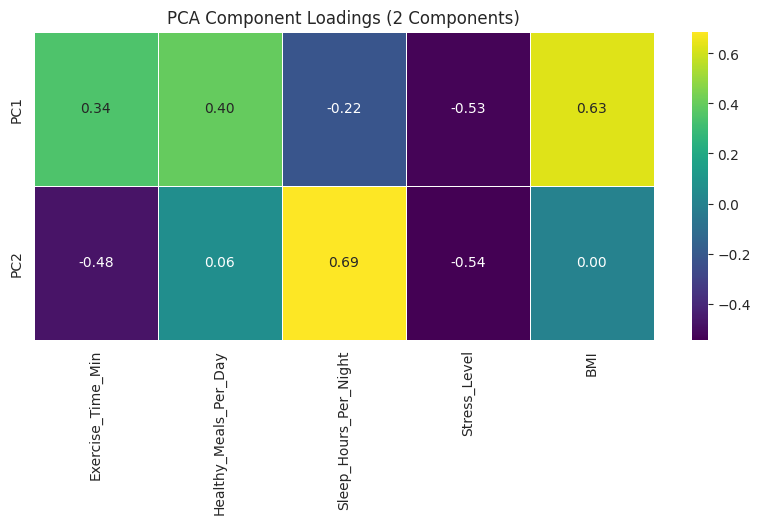

In [ ]:
# Block 5: Dimensionality Reduction - Principal Component Analysis (PCA)

print("\n--- Principal Component Analysis (PCA) ---")

# Fit PCA to the scaled data to determine explained variance
pca = PCA().fit(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Determine the number of components to retain (e.g., 80-90% variance)
# From the plot, choose a reasonable number. For demonstration, let's aim for ~90% or 2-3 components.
# Let's select components that explain at least 95% of the variance or a fixed number, e.g., 2 or 3.
# Let's choose 2 components for easier visualization and common practice.
n_components_pca = 2 # This value can be adjusted based on the elbow in the explained variance plot.

if n_components_pca > X_scaled.shape[1]:
    n_components_pca = X_scaled.shape[1]
    print(f"Warning: n_components ({n_components_pca}) is greater than number of features. Setting n_components to {n_components_pca}")

pca_final = PCA(n_components=n_components_pca)
X_pca = pca_final.fit_transform(X_scaled)

print(f"\nExplained Variance Ratio for {n_components_pca} PCA Components:")
print(pca_final.explained_variance_ratio_)
print(f"Total Explained Variance by {n_components_pca} components: {pca_final.explained_variance_ratio_.sum():.3f}")

# Interpret PCA components (Loadings)
# These loadings show the correlation between original features and the principal components.
pca_components_df = pd.DataFrame(pca_final.components_, columns=features_for_modeling, index=[f'PC{i+1}' for i in range(n_components_pca)])
print("\nPCA Components (Loadings - weights of original features on each PC):")
print(pca_components_df)

# A heatmap for loadings can be insightful
plt.figure(figsize=(10, (n_components_pca * 2)))
sns.heatmap(pca_components_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title(f'PCA Component Loadings ({n_components_pca} Components)')
plt.show()

In [ ]:
# Block 6: Clustering on PCA-Reduced Data and Model Comparison

print("\n--- Clustering on PCA-Reduced Data ---")

# K-Means on PCA-reduced data
kmeans_pca = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df['KMeans_PCA_Cluster'] = kmeans_pca.fit_predict(X_pca)

print(f"\nK-Means Clustering on PCA-reduced data Results (K={optimal_k}):")
print(df['KMeans_PCA_Cluster'].value_counts().sort_index())
print(f"Silhouette Score for K-Means (PCA Data): {silhouette_score(X_pca, df['KMeans_PCA_Cluster']):.3f}")

# Hierarchical Clustering on PCA-reduced data
hierarchical_pca = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df['Hierarchical_PCA_Cluster'] = hierarchical_pca.fit_predict(X_pca)

print(f"\nHierarchical Clustering on PCA-reduced data Results (K={optimal_k}):")
print(df['Hierarchical_PCA_Cluster'].value_counts().sort_index())
print(f"Silhouette Score for Hierarchical Clustering (PCA Data): {silhouette_score(X_pca, df['Hierarchical_PCA_Cluster']):.3f}")

print("\n--- Model Comparison ---")
print("Clustering Performance (Silhouette Score):")
print(f"K-Means (Original Data): {silhouette_score(X_scaled, df['KMeans_Cluster']):.3f}")
print(f"Hierarchical (Original Data): {silhouette_score(X_scaled, df['Hierarchical_Cluster']):.3f}")
print(f"K-Means (PCA Data): {silhouette_score(X_pca, df['KMeans_PCA_Cluster']):.3f}")
print(f"Hierarchical (PCA Data): {silhouette_score(X_pca, df['Hierarchical_PCA_Cluster']):.3f}")


print("\nK-Means Inertia (WCSS):")
print(f"K-Means (Original Data) Inertia: {kmeans.inertia_:.2f}")
print(f"K-Means (PCA Data) Inertia: {kmeans_pca.inertia_:.2f}")


print("\n--- Interpretation Guidance ---")
print("1. Compare Silhouette Scores: Higher scores indicate better-defined clusters.")
print("2. Analyze Cluster Means (from Block 3 and 4): Understand what defines each cluster (e.g., 'Cluster 0' has high stress, low sleep).")
print("3. Interpret PCA Loadings (from Block 5): Understand which original features contribute most to each principal component.")
print("4. Observe PCA Impact: Did PCA improve or worsen silhouette scores? If it improved, it means PCA helped in finding more distinct clusters by reducing noise or focusing on key variations.")
print("5. Visualize Clusters: The scatter plots help visually inspect separation.")


df.to_csv('clustered_health_wellness_data_with_pca.csv', index=False)
print("\nUpdated DataFrame with all cluster assignments saved to 'clustered_health_wellness_data_with_pca.csv'")


--- Clustering on PCA-Reduced Data ---

K-Means Clustering on PCA-reduced data Results (K=3):
KMeans_PCA_Cluster
0    63
1    62
2    75
Name: count, dtype: int64
Silhouette Score for K-Means (PCA Data): 0.362

Hierarchical Clustering on PCA-reduced data Results (K=3):
Hierarchical_PCA_Cluster
0    76
1    66
2    58
Name: count, dtype: int64
Silhouette Score for Hierarchical Clustering (PCA Data): 0.334

--- Model Comparison ---
Clustering Performance (Silhouette Score):
K-Means (Original Data): 0.155
Hierarchical (Original Data): 0.136
K-Means (PCA Data): 0.362
Hierarchical (PCA Data): 0.334

K-Means Inertia (WCSS):
K-Means (Original Data) Inertia: 725.45
K-Means (PCA Data) Inertia: 190.57

--- Interpretation Guidance ---
1. Compare Silhouette Scores: Higher scores indicate better-defined clusters.
2. Analyze Cluster Means (from Block 3 and 4): Understand what defines each cluster (e.g., 'Cluster 0' has high stress, low sleep).
3. Interpret PCA Loadings (from Block 5): Understand wh